# PandaRoot Simulation Plots

Plots of the **MC points** in the tracking systems of the PANDA detector, created with PandaRoot.

## Python Imports

Import the required python packages

In [158]:
# python IO for ROOT files
import uproot

# numpy
import numpy as np

# For interactive plotting
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.colors as mcolors
%matplotlib widget

# to get access to the pdg database 2024 version
import pdg
PdgApi = pdg.connect('sqlite:///../pdgall-2024-v0.1.0.sqlite')

## Global Parameters

Get/set the paths to the input and output files.

Path to the root files with the data that should be plotted:

In [159]:
rootFilePath = "/home/n_idw/simFiles/XiAntiXi/merged/root"

Path where the images should be saved

In [160]:
imagePath = "/mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization"

Name of the simulations (prefix) that should be plotted:

In [161]:
projectName = "XiAntiXi"


### Import Parameters

Import the parameters corresponding to the properties of the generated particels and their propagation through the detectors, from the corresponding root file.

Simulation root file:

In [162]:
simFile = rootFilePath  + "/" + projectName + "_sim.root"
print("Input simulation file: ",simFile)
mcPoint_params = uproot.open(simFile+":pndsim")

Input simulation file:  /home/n_idw/simFiles/XiAntiXi/merged/root/XiAntiXi_sim.root


#### MC Track : `MCTrack`

| Parameter Name	| Description 											| Unit	| Type			|	 Class							|
|-------------------|-------------------------------------------------------|-------|---------------|-----------------------------------|
| UniqueID			| Object unique identifier								| -		| UInt_t		| TObject							|
| Bits				| Bit field status word									| -		| UInt_t		| TObject 							|
| PdgCode			|														|		| Int_t			| PndMCTrack						|
| P(x,y,z)			|														|		| Double32_t	| PndMCTrack						|
| E					|														|		| Double32_t	| PndMCTrack						|
| MotherID			|														|		| Int_t			| PndMCTrack						|
| SecondMotherID	|														|		| Int_t			| PndMCTrack						|
| GeneratorFlags	|														|		| Int_t			| PndMCTrack						|
| Start(X,Y,Z)		|														|		| Double32_t	| PndMCTrack						|
| StartT			|														|		| Double32_t	| PndMCTrack						|
| Points			|														|		| Int_t			| PndMCTrack						|
| Process			|														|		| UInt_t		| PndMCTrack						|

#### Straw Tube Detector (STT) : `STTPoint`

pos and mom are given in x, y, and z coordinates in the lab frame

| Parameter Name	| Description 											| Unit	| Type			|	 Class							|
|-------------------|-------------------------------------------------------|-------|---------------|-----------------------------------|
| UniqueID			| Object unique identifier								| -		| UInt_t		| TObject							|
| Bits				| Bit field status word									| -		| UInt_t		| TObject 							|
| Link				| 														| -		| unique_ptr	| FairMultiLinkedData_Interface		|
| TrackID			| Track index											| -		| Int_t			| FairMCPoint						|
| EventId			| MC Event id											| -		| UInt_t		| FairMCPoint						|
| P(x,y,z)			| Momentum components									| GeV	| Double32_t	| FairMCPoint						|
| Time				| Time since event start								| ns	| Double32_t	| FairMCPoint						|
| Length			| Track length since creation							| cm	| Double32_t	| FairMCPoint						|
| ELoss				| Energy loss at this point								| GeV	| Double32_t	| FairMCPoint						|
| DetectorID		| Detector unique identifier 							| -		| Int_t			| FairMCPoint						|
| (X,Y,Z)			| Position of hit 										| cm	| Double32_t	| FairMCPoint						|
| (X,Y,Z)_out_local	| Exit coordinates in straw frame						|		| Double_t		| PndSttPoint						|
| (X,Y,Z)_in_local	| Entry coordinates in straw frame						|		| Double_t		| PndSttPoint						|
| P(x,y,z)_in		| *unused member*										|		| Double_t		| PndSttPoint						|
| P(x,y,z)_out		| 														|		| Double_t		| PndSttPoint						|
| Mass				| Particle mass											|		| Double_t		| PndSttPoint						|
| TubeID			| Tube ID												|		| Int_t			| PndSttPoint						|

#### Micro Vertex Detector (MVD) : `MVDPoint`

pos and mom are given in x, y, and z coordinates in the lab frame

| Parameter Name	| Description 											| Unit	| Type			|	 Class							|
|-------------------|-------------------------------------------------------|-------|---------------|-----------------------------------|
| UniqueID			| Object unique identifier								| -		| UInt_t		| TObject							|
| Bits				| Bit field status word									| -		| UInt_t		| TObject 							|
| Link				| 														| -		| unique_ptr	| FairMultiLinkedData_Interface		|
| TrackID			| Track index											| -		| Int_t			| FairMCPoint						|
| EventId			| MC Event id											| -		| UInt_t		| FairMCPoint						|
| P(x,y,z)			| Momentum components									| GeV	| Double32_t	| FairMCPoint						|
| Time				| Time since event start								| ns	| Double32_t	| FairMCPoint						|
| Length			| Track length since creation							| cm	| Double32_t	| FairMCPoint						|
| ELoss				| Energy loss at this point								| GeV	| Double32_t	| FairMCPoint						|
| DetectorID		| Detector unique identifier 							| -		| Int_t			| FairMCPoint						|
| (X,Y,Z)			| Position of hit 										| cm	| Double32_t	| FairMCPoint						|
| (X,Y,Z)Out		| 														|		| Double32_t	| PndMCPoint						|
| P(x,y,z)Out		| 														|		| Double32_t	| PndMCPoint						|
| SensorID			| 														|		| Int_t			| PndSdsMCPoint 					|

## Plots

### Plot xy-Projections with Colormaps for various Parameters

#### Some Helper Functions

In [163]:
# This function creates a dictionary with the trackID as the key and arrays with track parameters (coordinates, momenta, etc.)
# corresponding to the trackID as the values
# Arguments:
# trackIDs		: Array with trackIDs
# trackParameter: Array with track parameters
# trackDict		: Dictionary with trackID as the key and arrays with track parameters as the values
def makeTrackDict(trackIDs, trackParameter, trackDict):
	point = 0
 	# Iterate over all track IDs
	for trackID in trackIDs:
		if trackID not in trackDict:
			trackDict[trackID]  = np.zeros(0)
		trackDict[trackID]  = np.append(trackDict[trackID], trackParameter[point])
		point += 1
	return trackDict


#### Set the Parameters for the Plots

In [164]:
eventNumber = 94612

# Get MC Track parameters
mcTrack_pdgId = mcPoint_params["MCTrack.fPdgCode"].array(library="np")[eventNumber]

# Get STT parameters

# Coordinates
stt_x = mcPoint_params["STTPoint.fX"].array(library="np")[eventNumber]
stt_y = mcPoint_params["STTPoint.fY"].array(library="np")[eventNumber]
stt_z = mcPoint_params["STTPoint.fZ"].array(library="np")[eventNumber]

# Momenta
stt_px = mcPoint_params["STTPoint.fPx"].array(library="np")[eventNumber]
stt_py = mcPoint_params["STTPoint.fPy"].array(library="np")[eventNumber]
stt_pz = mcPoint_params["STTPoint.fPz"].array(library="np")[eventNumber]

# Time
stt_t = mcPoint_params["STTPoint.fTime"].array(library="np")[eventNumber]

# Energy loss
stt_dE = mcPoint_params["STTPoint/STTPoint.fELoss"].array(library="np")[eventNumber]

# Track ID
stt_trackIDs = mcPoint_params["STTPoint.fTrackID"].array(library="np")[eventNumber]

# Get MVD parameters

# Coordinates
mvd_x = mcPoint_params["MVDPoint.fX"].array(library="np")[eventNumber]
mvd_y = mcPoint_params["MVDPoint.fY"].array(library="np")[eventNumber]
mvd_z = mcPoint_params["MVDPoint.fZ"].array(library="np")[eventNumber]

# Momenta
mvd_px = mcPoint_params["MVDPoint.fPx"].array(library="np")[eventNumber]
mvd_py = mcPoint_params["MVDPoint.fPy"].array(library="np")[eventNumber]
mvd_pz = mcPoint_params["MVDPoint.fPz"].array(library="np")[eventNumber]

# Time
mvd_t = mcPoint_params["MVDPoint.fTime"].array(library="np")[eventNumber]

# Energy loss
mvd_dE = mcPoint_params["MVDPoint/MVDPoint.fELoss"].array(library="np")[eventNumber]

# Track ID
mvd_trackIDs = mcPoint_params["MVDPoint.fTrackID"].array(library="np")[eventNumber]

# Normalize the xy-projections of the momenta
stt_totMom = np.sqrt(stt_px**2 + stt_py**2)
mvd_totMom = np.sqrt(mvd_px**2 + mvd_py**2)

stt_normPx = stt_px/stt_totMom
stt_normPy = stt_py/stt_totMom

mvd_normPx = mvd_px/mvd_totMom
mvd_normPy = mvd_py/mvd_totMom

# get the absolute momenta
stt_p = np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)
mvd_p = np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)

# Define dictionaries with the trackID as the key and arrays with x, y & z coordinates and momenta as the values
xPointsPerTrack = {}
xPointsPerTrack = makeTrackDict(stt_trackIDs, stt_x, xPointsPerTrack)
xPointsPerTrack = makeTrackDict(mvd_trackIDs, mvd_x, xPointsPerTrack)

yPointsPerTrack = {}
yPointsPerTrack = makeTrackDict(stt_trackIDs, stt_y, yPointsPerTrack)
yPointsPerTrack = makeTrackDict(mvd_trackIDs, mvd_y, yPointsPerTrack)

zPointsPerTrack = {}
zPointsPerTrack = makeTrackDict(stt_trackIDs, stt_z, zPointsPerTrack)
zPointsPerTrack = makeTrackDict(mvd_trackIDs, mvd_z, zPointsPerTrack)

xMomentaPerTrack = {}
xMomentaPerTrack = makeTrackDict(stt_trackIDs, stt_px, xMomentaPerTrack)
xMomentaPerTrack = makeTrackDict(mvd_trackIDs, mvd_px, xMomentaPerTrack)

yMomentaPerTrack = {}
yMomentaPerTrack = makeTrackDict(stt_trackIDs, stt_py, yMomentaPerTrack)
yMomentaPerTrack = makeTrackDict(mvd_trackIDs, mvd_py, yMomentaPerTrack)

zMomentaPerTrack = {}
zMomentaPerTrack = 	makeTrackDict(stt_trackIDs, stt_pz, zMomentaPerTrack)
zMomentaPerTrack = 	makeTrackDict(mvd_trackIDs, mvd_pz, zMomentaPerTrack)


#### z-Position

Min z:  9.970000267028809  cm
Max z:  46.88032150268555  cm
Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjection_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjection_94612.pdf


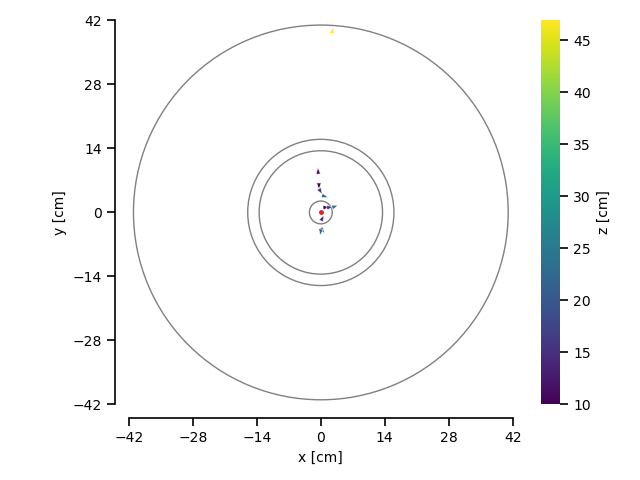

In [165]:
# find out what the maximum and minimum z values are
z_coords = np.concatenate((stt_z, mvd_z))
min_z = np.min(z_coords)
print("Min z: ", np.min(z_coords), " cm")
max_z = np.max(z_coords)
print("Max z: ", np.max(z_coords), " cm")

# Create a normalization object
zNorm = mcolors.Normalize(vmin=min_z, vmax=max_z)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# Plot the inner and outer MVD radii
mvdInner = patches.Circle((0,0), radius=2.5, color='gray', fill=False)
ax.add_patch(mvdInner)

mvdOuter = patches.Circle((0,0), radius=13.5, color='gray', fill=False)
ax.add_patch(mvdOuter)

# Plot the inner and outer STT radii
sttInner = patches.Circle((0,0), radius=16.0, color='gray', fill=False)
ax.add_patch(sttInner)

sstOuter = patches.Circle((0,0), radius=41.0, color='gray', fill=False)
ax.add_patch(sstOuter)

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the z coordinate
plt.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_z, pivot='mid', cmap='viridis', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=zNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_x, mvd_y, mvd_normPx, mvd_normPy, mvd_z, pivot='mid', cmap='viridis', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=zNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the axis labels and limits
plt.xlabel("x [cm]")
plt.xlim(-42, 42)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-42, 42, num=7)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

# Add and format the color bar 
cbar = plt.colorbar(label="z [cm]")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

fig.tight_layout()	

imgPath = imagePath + "/sim/" + projectName + "_xyProjection_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Time

Min t:  0.4179002344608307  ns
Max t:  2.8287789821624756  ns
Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjectionTime_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjectionTime_94612.pdf


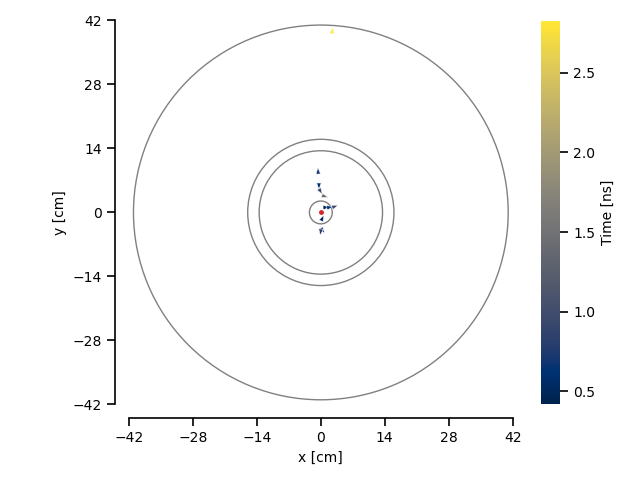

In [166]:
# find out what the maximum and minimum t values are
times = np.concatenate((stt_t, mvd_t))
min_t = np.min(times)
print("Min t: ", min_t, " ns")
max_t = np.max(times)
print("Max t: ", max_t, " ns")

# Create a normalization object
tNorm = mcolors.Normalize(vmin=min_t, vmax=max_t)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# Plot the inner and outer MVD radii
mvdInner = patches.Circle((0,0), radius=2.5, color='gray', fill=False)
ax.add_patch(mvdInner)

mvdOuter = patches.Circle((0,0), radius=13.5, color='gray', fill=False)
ax.add_patch(mvdOuter)

# Plot the inner and outer STT radii
sttInner = patches.Circle((0,0), radius=16.0, color='gray', fill=False)
ax.add_patch(sttInner)

sstOuter = patches.Circle((0,0), radius=41.0, color='gray', fill=False)
ax.add_patch(sstOuter)

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the color representing the time
plt.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_t, pivot='mid', cmap='cividis', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_x, mvd_y, mvd_normPx, mvd_normPy, mvd_t, pivot='mid', cmap='cividis', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the axis labels and limits
plt.xlabel("x [cm]")
plt.xlim(-42, 42)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-42, 42, num=7)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

# Add and format the color bar 
cbar = plt.colorbar(label="Time [ns]")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

fig.tight_layout()	

imgPath = imagePath + "/sim/" + projectName + "_xyProjectionTime_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Momentum

Min p:  0.07691628946125015  GeV
Max p:  2.688731041713449  GeV
Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjectionMomentum_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjectionMomentum_94612.pdf


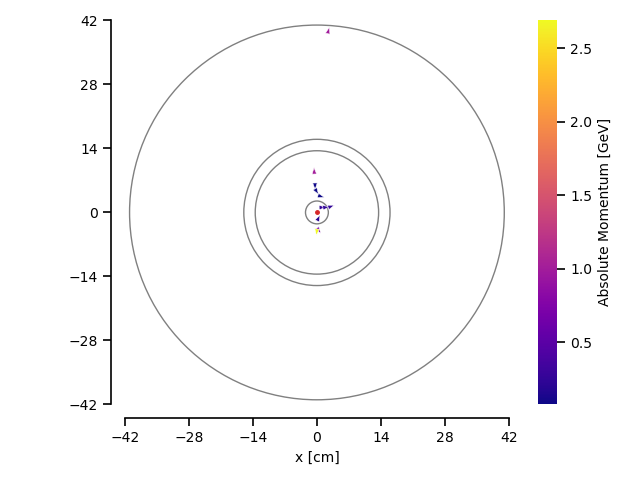

In [167]:
# find out what the maximum and minimum p values are
momenta = np.concatenate((stt_p, mvd_p))
min_p = np.min(momenta)
print("Min p: ", min_p, " GeV")
max_p = np.max(momenta)
print("Max p: ", max_p, " GeV")

# Create a normalization object
pNorm = mcolors.Normalize(vmin=min_p, vmax=max_p)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# Plot the inner and outer MVD radii
mvdInner = patches.Circle((0,0), radius=2.5, color='gray', fill=False)
ax.add_patch(mvdInner)

mvdOuter = patches.Circle((0,0), radius=13.5, color='gray', fill=False)
ax.add_patch(mvdOuter)

# Plot the inner and outer STT radii
sttInner = patches.Circle((0,0), radius=16.0, color='gray', fill=False)
ax.add_patch(sttInner)

sstOuter = patches.Circle((0,0), radius=41.0, color='gray', fill=False)
ax.add_patch(sstOuter)

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the absolute momentum
plt.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_p, pivot='mid', cmap='plasma', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_x, mvd_y, mvd_normPx, mvd_normPy, mvd_p, pivot='mid', cmap='plasma', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the axis labels and limits
plt.xlabel("x [cm]")
plt.xlim(-42, 42)
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-42, 42, num=7)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

# Add and format the color bar 
cbar = plt.colorbar(label="Absolute Momentum [GeV]")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

fig.tight_layout()	

imgPath = imagePath + "/sim/" + projectName + "_xyProjectionMomentum_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Energy Loss

Min dE:  4.8810034058988094e-06  GeV
Max dE:  0.00019103613158222288  GeV
Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjectionEnergyLoss_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyProjectionEnergyLoss_94612.pdf


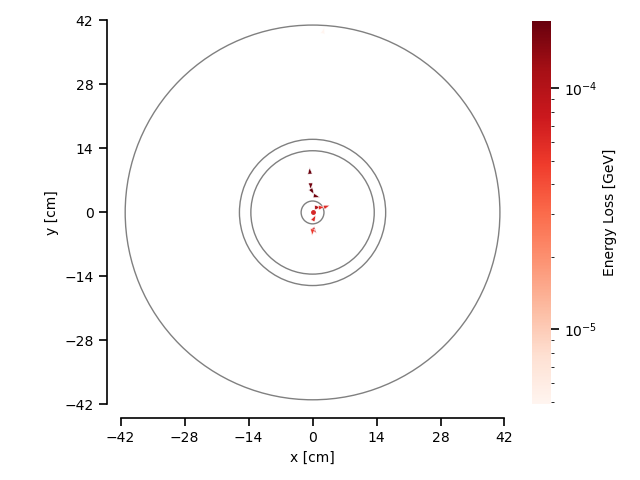

In [168]:
# find out what the maximum and minimum dE values are
energyLoss = np.concatenate((stt_dE, mvd_dE))
min_dE = np.min(energyLoss)
print("Min dE: ", min_dE, " GeV")
max_dE = np.max(energyLoss)
print("Max dE: ", max_dE, " GeV")

# Create a normalization object
dENorm = mcolors.LogNorm(vmin=min_dE, vmax=max_dE)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# Plot the inner and outer MVD radii
mvdInner = patches.Circle((0,0), radius=2.5, color='gray', fill=False)
ax.add_patch(mvdInner)

mvdOuter = patches.Circle((0,0), radius=13.5, color='gray', fill=False)
ax.add_patch(mvdOuter)

# Plot the inner and outer STT radii
sttInner = patches.Circle((0,0), radius=16.0, color='gray', fill=False)
ax.add_patch(sttInner)

sstOuter = patches.Circle((0,0), radius=41.0, color='gray', fill=False)
ax.add_patch(sstOuter)

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the absolute momentum
plt.quiver(stt_x, stt_y, stt_normPx, stt_normPy, stt_dE, pivot='mid', cmap='Reds', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_x, mvd_y, mvd_normPx, mvd_normPy, mvd_dE, pivot='mid', cmap='Reds', scale=0.7, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the axis labels and limits
plt.xlabel("x [cm]")
plt.xlim(-42, 42)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-42, 42, num=7)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

# Add and format the color bar 
cbar = plt.colorbar(label="Energy Loss [GeV]")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

fig.tight_layout()	

imgPath = imagePath + "/sim/" + projectName + "_xyProjectionEnergyLoss_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Tracks

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyTracks_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xyTracks_94612.pdf


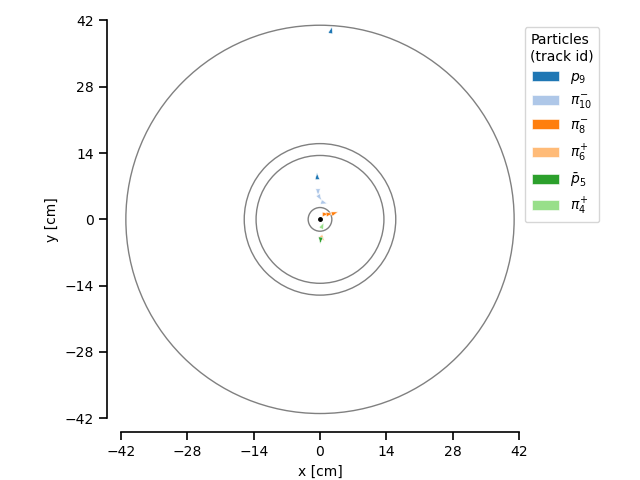

In [169]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='black')

# Plot the inner and outer MVD radii
mvdInner = patches.Circle((0,0), radius=2.50, color='gray', fill=False)
ax.add_patch(mvdInner)
mvdOuter = patches.Circle((0,0), radius=13.5, color='gray', fill=False)
ax.add_patch(mvdOuter)

# Plot the inner and outer STT radii
sttInner = patches.Circle((0,0), radius=16.0, color='gray', fill=False)
ax.add_patch(sttInner)
sstOuter = patches.Circle((0,0), radius=41.0, color='gray', fill=False)
ax.add_patch(sstOuter)

# Get the tab20 colormap
tab20 = plt.colormaps['tab20']
colorNum = 0

for trackID in xPointsPerTrack:
	if mcTrack_pdgId[trackID] == 13:
		trackLabel = r'$\mu^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -13:
		trackLabel = r'$\mu^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 11:
		trackLabel = r'$e^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -11:
		trackLabel = r'$e^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 211:
		trackLabel = r'$\pi^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -211:
		trackLabel = r'$\pi^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 2212:
		trackLabel = r'$p_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -2212:
		trackLabel = r'$\bar{p}_{'+ str(trackID) +r'}$'
	else:
		trackLabel: str = "PDG ID: " + str(mcTrack_pdgId[trackID])
	tab20color = tab20(colorNum % 20)
	trackNormPx=xMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + yMomentaPerTrack[trackID]**2)
	trackNormPy=yMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + yMomentaPerTrack[trackID]**2)
	ax.quiver(xPointsPerTrack[trackID], yPointsPerTrack[trackID], trackNormPx, trackNormPy, pivot='middle', angles='xy', scale_units='xy',
           lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001, units='xy', scale=0.7,
           color=tab20color, label=trackLabel)
	colorNum += 1

# Set the axis labels and limits
plt.xlabel("x [cm]")
plt.xlim(-42, 42)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-42, 42, num=7)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

fig.tight_layout()	

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.legend(title="Particles\n(track id)",loc="upper right",ncols=1,bbox_to_anchor=(1.22,1.0))

imgPath = imagePath + "/sim/" + projectName + "_xyTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

### Plot xz-Projections with Colormaps for various Parameters

In [170]:
# Normalize the momenta to the xz-projection
stt_normPx = stt_px/np.sqrt(stt_px**2 + stt_pz**2)
stt_normPz = stt_pz/np.sqrt(stt_px**2 + stt_pz**2)

mvd_normPx = mvd_px/np.sqrt(mvd_px**2 + mvd_pz**2)
mvd_normPz = mvd_pz/np.sqrt(mvd_px**2 + mvd_pz**2)


#### y-Position

Min y:  -4.333568096160889  cm
Max y:  39.95966720581055  cm
Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjection_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjection_94612.pdf


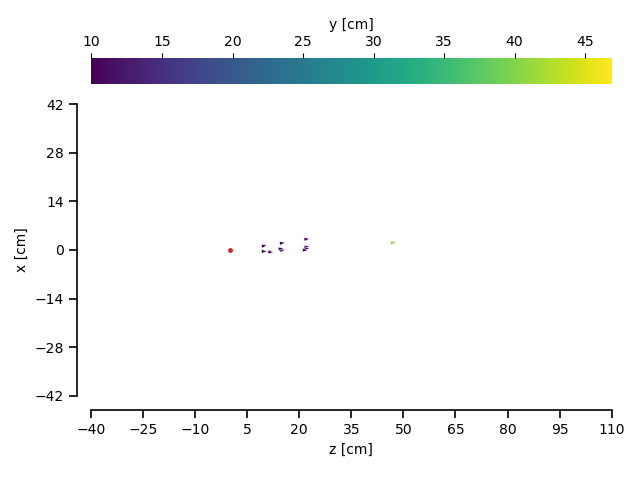

In [171]:
# find out what the maximum and minimum x values are
y_coords = np.concatenate((stt_y, mvd_y))
min_y = np.min(y_coords)
print("Min y: ", min_y, " cm")
max_y = np.max(y_coords)
print("Max y: ", max_y, " cm")

# Create a normalization object
yNorm = mcolors.Normalize(vmin=min_y, vmax=max_y)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the z coordinate
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_y, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=zNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_y, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=zNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)

# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="y [cm]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_xzProjection_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Time

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjectionTime_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjectionTime_94612.pdf


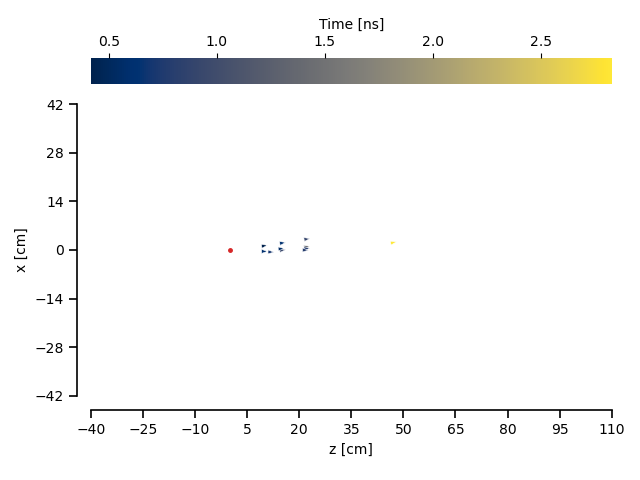

In [172]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the time
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Time [ns]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_xzProjectionTime_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Momentum

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjectionMomentum_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjectionMomentum_94612.pdf


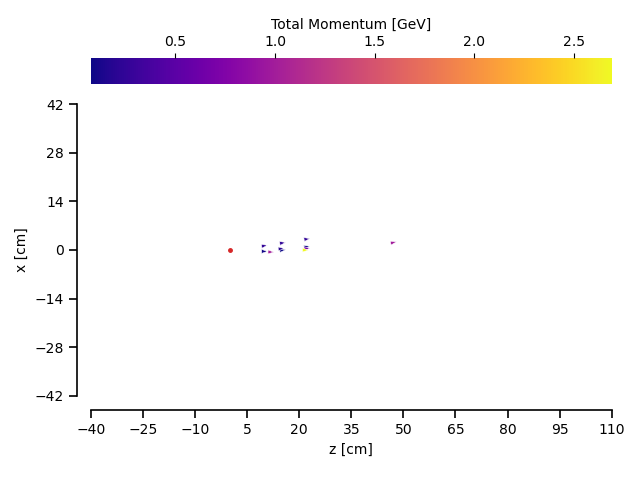

In [173]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Total Momentum [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_xzProjectionMomentum_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Energy Loss

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjectionEnergyLoss_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzProjectionEnergyLoss_94612.pdf


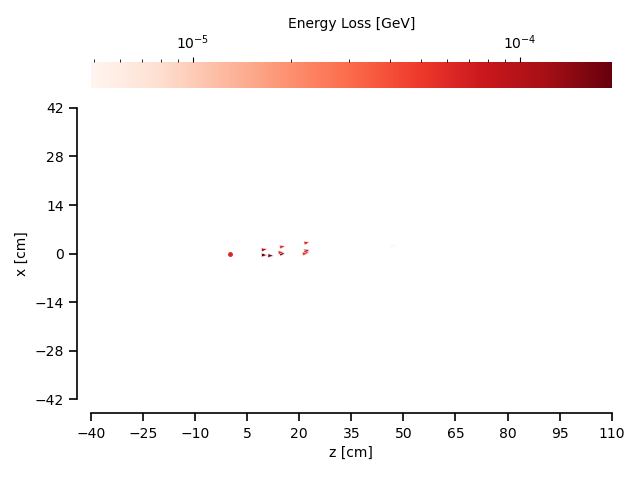

In [174]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_x, stt_normPz, stt_normPx, stt_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_x, mvd_normPz, mvd_normPx, mvd_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Energy Loss [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_xzProjectionEnergyLoss_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Tracks

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzTracks_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_xzTracks_94612.pdf


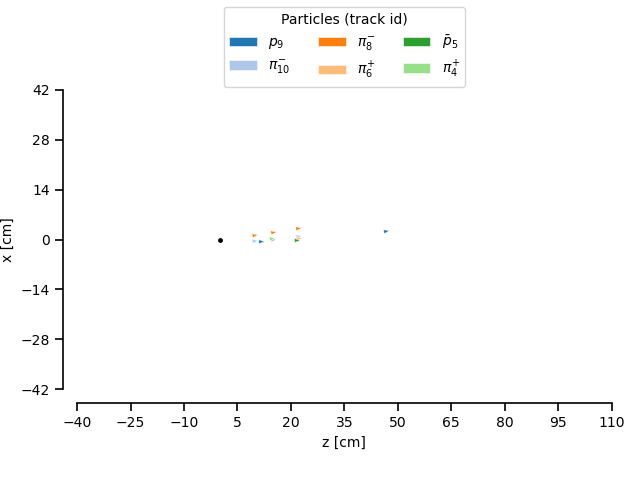

In [175]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='black')

# Get the tab20 colormap
tab20 = plt.colormaps['tab20']
colorNum = 0

for trackID in xPointsPerTrack:
	if mcTrack_pdgId[trackID] == 13:
		trackLabel = r'$\mu^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -13:
		trackLabel = r'$\mu^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 11:
		trackLabel = r'$e^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -11:
		trackLabel = r'$e^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 211:
		trackLabel = r'$\pi^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -211:
		trackLabel = r'$\pi^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 2212:
		trackLabel = r'$p_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -2212:
		trackLabel = r'$\bar{p}_{'+ str(trackID) +r'}$'
	else:
		trackLabel: str = "PDG ID: " + str(mcTrack_pdgId[trackID])
	tab20color = tab20(colorNum % 20)
	trackNormPx=xMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	trackNormPz=zMomentaPerTrack[trackID]/np.sqrt(xMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	ax.quiver(zPointsPerTrack[trackID], xPointsPerTrack[trackID], trackNormPz, trackNormPx, pivot='middle',
           angles='xy', scale_units='xy', units='xy', scale=0.6,lw=0.4, edgecolor='white', headwidth=3.5, 
           headlength=5, headaxislength=5, minlength=0.001 ,color=tab20color, label=trackLabel)
	colorNum += 1

# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("x [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

fig.tight_layout()	

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.legend(title="Particles (track id)",loc="upper center",ncols=len(xPointsPerTrack)/2,bbox_to_anchor=(0.5,1.3))

imgPath = imagePath + "/sim/" + projectName + "_xzTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

### Plot yz-Projections with Colormaps for various Parameters

In [176]:
# Normalize the momenta to the xz-projection
stt_normPy = stt_py/np.sqrt(stt_py**2 + stt_pz**2)
stt_normPz = stt_pz/np.sqrt(stt_py**2 + stt_pz**2)

mvd_normPy = mvd_py/np.sqrt(mvd_py**2 + mvd_pz**2)
mvd_normPz = mvd_pz/np.sqrt(mvd_py**2 + mvd_pz**2)


#### x-Position

Min x:  -0.5983485579490662  cm
Max x:  3.1331000328063965  cm
Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjection_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjection_94612.pdf


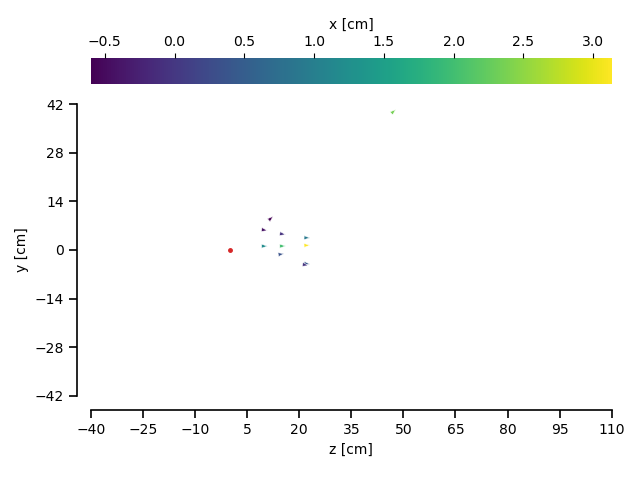

In [177]:
# find out what the maximum and minimum x values are
x_coords = np.concatenate((stt_x, mvd_x))
min_x = np.min(x_coords)
print("Min x: ", min_x, " cm")
max_x = np.max(x_coords)
print("Max x: ", max_x, " cm")

# Create a normalization object
xNorm = mcolors.Normalize(vmin=min_x, vmax=max_x)

fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the z coordinate
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_x, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=xNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_x, pivot='mid', cmap='viridis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=xNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="x [cm]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjection_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Time

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjectionTime_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjectionTime_94612.pdf


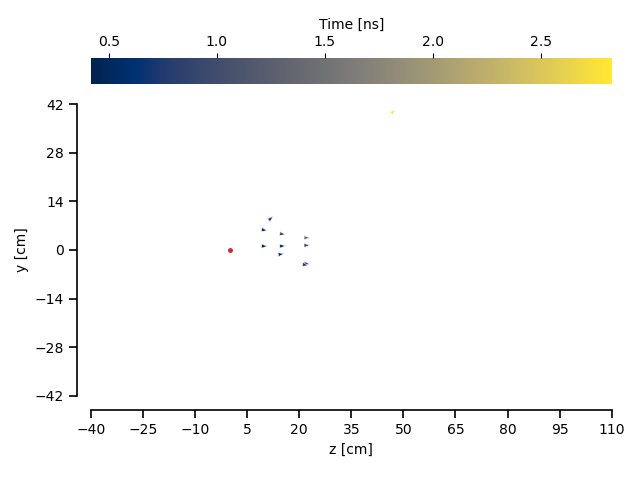

In [178]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the time
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_t, pivot='mid', cmap='cividis', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=tNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Time [ns]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjectionTime_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Momentum

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjectionMomentum_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjectionMomentum_94612.pdf


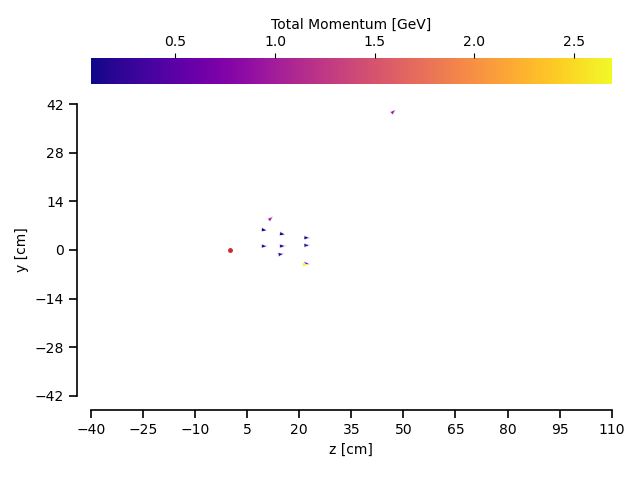

In [179]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_p, pivot='mid', cmap='plasma', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=pNorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Total Momentum [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjectionMomentum_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Energy Loss

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjectionEnergyLoss_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzProjectionEnergyLoss_94612.pdf


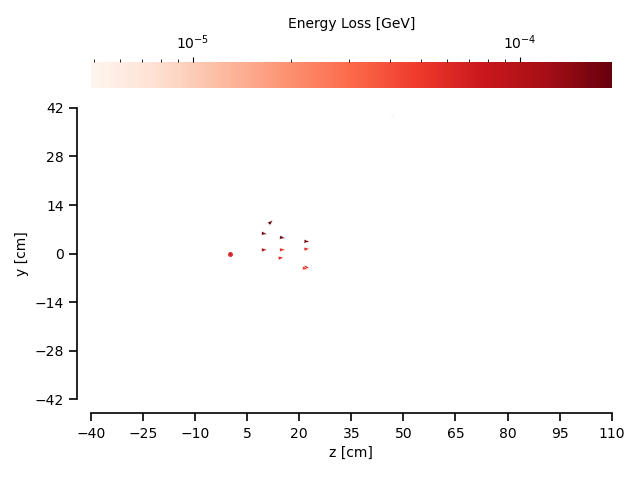

In [180]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='tab:red')

# plot the STT & MVD MC points as arrows with the arrow direction being the momentum direction and the 
# color representing the momentum
plt.quiver(stt_z, stt_y, stt_normPz, stt_normPy, stt_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)
plt.quiver(mvd_z, mvd_y, mvd_normPz, mvd_normPy, mvd_dE, pivot='mid', cmap='Reds', scale=0.6, scale_units='xy', angles='xy',
           units='xy', norm=dENorm, lw=0.4, edgecolor='white', headwidth=3.5, headlength=5, headaxislength=5, minlength=0.001)


# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Make the axis look fancier
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add and format the color bar
cbar = plt.colorbar(label="Energy Loss [GeV]",orientation='horizontal',location="top")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
ax.set_aspect('equal')

fig.tight_layout()

imgPath = imagePath + "/sim/" + projectName + "_yzProjectionEnergyLoss_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

#### Tracks

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzTracks_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_yzTracks_94612.pdf


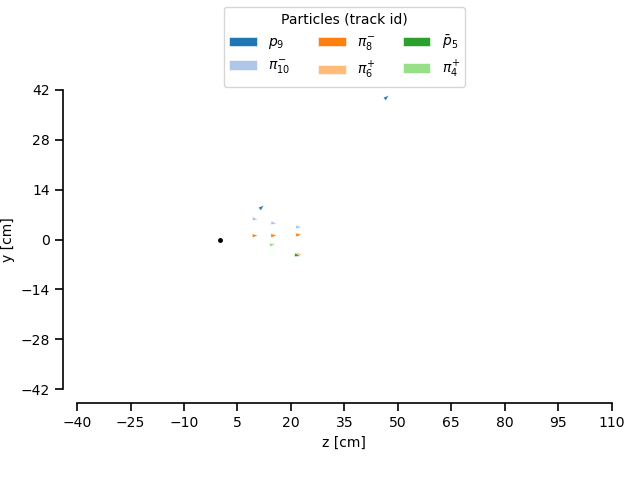

In [181]:
fig = plt.figure()
ax = fig.add_subplot()

# Plot the IP
plt.plot(0,0,marker='.',ms=5, color='black')

# Get the tab20 colormap
tab20 = plt.colormaps['tab20']
colorNum = 0

for trackID in xPointsPerTrack:
	if mcTrack_pdgId[trackID] == 13:
		trackLabel = r'$\mu^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -13:
		trackLabel = r'$\mu^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 11:
		trackLabel = r'$e^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -11:
		trackLabel = r'$e^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 211:
		trackLabel = r'$\pi^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -211:
		trackLabel = r'$\pi^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 2212:
		trackLabel = r'$p_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -2212:
		trackLabel = r'$\bar{p}_{'+ str(trackID) +r'}$'
	else:
		trackLabel: str = "PDG ID: " + str(mcTrack_pdgId[trackID])
	tab20color = tab20(colorNum % 20)
	trackNormPy=yMomentaPerTrack[trackID]/np.sqrt(yMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	trackNormPz=zMomentaPerTrack[trackID]/np.sqrt(yMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	ax.quiver(zPointsPerTrack[trackID], yPointsPerTrack[trackID], trackNormPz, trackNormPy, pivot='middle',
           angles='xy', scale_units='xy', units='xy', scale=0.6,lw=0.4, edgecolor='white', headwidth=3.5, 
           headlength=5, headaxislength=5, minlength=0.001 ,color=tab20color, label=trackLabel)
	colorNum += 1

# Set the axis labels and limits
plt.xlabel("z [cm]")
plt.xlim(-40, 110)
plt.ylabel("y [cm]")
plt.ylim(-42, 42)

# Set the ticks positions to match the data range
x_ticks = np.linspace(-40, 110, num=11)
y_ticks = np.linspace(-42, 42, num=7)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.tick_params(length=6,width=1.2)

# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

fig.tight_layout()	

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

plt.legend(title="Particles (track id)",loc="upper center",ncols=len(xPointsPerTrack)/2,bbox_to_anchor=(0.5,1.3))

imgPath = imagePath + "/sim/" + projectName + "_yzTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')

### 3D Scatter Plot

In [182]:
# Normalize the momenta
stt_normPx = stt_px / np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)
stt_normPy = stt_py / np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)
stt_normPz = stt_pz / np.sqrt(stt_px**2 + stt_py**2 + stt_pz**2)

mvd_normPx = mvd_px / np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)
mvd_normPy = mvd_py / np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)
mvd_normPz = mvd_pz / np.sqrt(mvd_px**2 + mvd_py**2 + mvd_pz**2)

Saving png image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_3dTracks_94612.png
Saving pdf image to:  /mnt/c/Users/nikol/sciebo/Doktor/Pictures/simulation-visualization/sim/XiAntiXi_3dTracks_94612.pdf


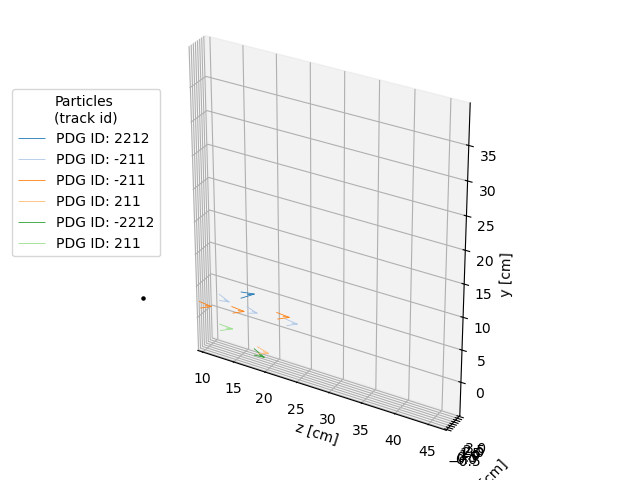

In [183]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

# Plot the IP
scatter=ax.scatter(0,0,0,marker='.', color='black')

# Set the axis labels and limits
xCoords = np.concatenate((stt_x, mvd_x))
yCoords = np.concatenate((stt_y, mvd_y))
zCoords = np.concatenate((stt_z, mvd_z))

min_x = np.min(xCoords)
max_x = np.max(xCoords)
min_y = np.min(yCoords)
max_y = np.max(yCoords)
min_z = np.min(zCoords)
max_z = np.max(zCoords)

plt.xlabel("z [cm]")
plt.xlim(min_z, max_z)
plt.ylabel("x [cm]")
plt.ylim(min_x, max_x)
ax.set_zlabel("y [cm]")
ax.set_zlim(min_y, max_y)

# Get the tab20 colormap
tab20 = plt.colormaps['tab20']
colorNum = 0

for trackID in yPointsPerTrack:
	if mcTrack_pdgId[trackID] == 13:
		trackLabel = r'$\mu^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -13:
		trackLabel = r'$\mu^{+}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == 11:
		trackLabel = r'$e^{-}_{'+ str(trackID) +r'}$'
	elif mcTrack_pdgId[trackID] == -11:
		trackLabel = r'$e^{+}_{'+ str(trackID) +r'}$'
	else:
		trackLabel = "PDG ID: " + str(mcTrack_pdgId[trackID])
	tab20color = tab20(colorNum % 20)
	trackAbsMom = np.sqrt(xMomentaPerTrack[trackID]**2 + yMomentaPerTrack[trackID]**2 + zMomentaPerTrack[trackID]**2)
	trackNormPx=xMomentaPerTrack[trackID]/trackAbsMom
	trackNormPy=yMomentaPerTrack[trackID]/trackAbsMom
	trackNormPz=zMomentaPerTrack[trackID]/trackAbsMom
	ax.quiver(zPointsPerTrack[trackID], yPointsPerTrack[trackID], xPointsPerTrack[trackID], trackNormPz,
			trackNormPy, trackNormPx, pivot='middle' ,color=tab20color, label=trackLabel, length=1,
   			normalize=True, arrow_length_ratio=2, lw=0.6)
	colorNum += 1


# Set the aspect ratio to be equal
plt.gca().set_aspect('equal')

fig.tight_layout()	

plt.legend(title="Particles\n(track id)", loc="upper left",ncol=1,bbox_to_anchor=(-0.2,0.85))

imgPath = imagePath + "/sim/" + projectName + "_3dTracks_" + str(eventNumber)

print("Saving png image to: ", imgPath+".png")
plt.savefig(imgPath+".png", dpi=300, bbox_inches='tight')

print("Saving pdf image to: ", imgPath+".pdf")
plt.savefig(imgPath+".pdf", dpi=300, bbox_inches='tight')